# Setup

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.framework import ops

%matplotlib inline

np.random.seed(1)

# Helper Functions

- Data

In [2]:
def load_dataset():
    
    train_dataset = h5py.File('./train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])

    test_dataset = h5py.File('./test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])

    classes = np.array(test_dataset["list_classes"][:])
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

- Processing

In [3]:
def onehot_encoder(Y, C):
    '''
    One-hot encode label array to matrix
        - C: integer, the number of classes
    '''
    
    return np.eye(C)[Y.reshape(-1)].T

- Mini-batch

In [4]:
def random_mini_batches(X, Y, batch_size=64, seed=0):
    '''
    Generate a list of random mini-batches from (X, Y)
    '''
    
    np.random.seed(seed)
    
    m = X.shape[1]
    mini_batches = []
    
    # Permutation
    shuffle = np.random.permutation(m)
    shuffled_X = X[:, shuffle]
    shuffled_Y = Y[:, shuffle]
    
    # Partition
    n_full_batches = m//batch_size
    
    for k in range(n_full_batches):
        mini_batch_X = shuffled_X[:, k*batch_size: (k+1)*batch_size]
        mini_batch_Y = shuffled_Y[:, k*batch_size: (k+1)*batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    if m % batch_size != 0:
        mini_batch_X = shuffled_X[:, n_full_batches*batch_size:]
        mini_batch_Y = shuffled_Y[:, n_full_batches*batch_size:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

# Modules

- Create placeholders for X and Y

In [5]:
def create_placeholders(n_x, n_y):
    '''
    Create placeholders for X and Y in the tensorflow session
        - n_x: integer, size of an image vector
        - n_y: integer, number of classes
    '''
    
    X = tf.placeholder(dtype=tf.float32, shape=[n_x, None], name='X')
    Y = tf.placeholder(dtype=tf.float32, shape=[n_y, None], name='Y')
    
    return X, Y

- Initialize the parameters

In [6]:
def random_mini_batches(X, Y, batch_size=64, seed=0):
    '''
    Generate a list of random mini-batches from (X, Y)
    '''
    
    np.random.seed(seed)
    
    m = X.shape[1]
    mini_batches = []
    
    # Permutation
    shuffle = np.random.permutation(m)
    shuffled_X = X[:, shuffle]
    shuffled_Y = Y[:, shuffle]
    
    # Partition
    n_full_batches = m//batch_size
    
    for k in range(n_full_batches):
        mini_batch_X = shuffled_X[:, k*batch_size: (k+1)*batch_size]
        mini_batch_Y = shuffled_Y[:, k*batch_size: (k+1)*batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    if m % batch_size != 0:
        mini_batch_X = shuffled_X[:, n_full_batches*batch_size:]
        mini_batch_Y = shuffled_Y[:, n_full_batches*batch_size:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

def create_placeholders(n_x, n_y):
    '''
    Create placeholders for X and Y in the tensorflow session
        - n_x: integer, size of an image vector
        - n_y: integer, number of classes
    '''
    
    X = tf.placeholder(dtype=tf.float32, shape=[n_x, None], name='X')
    Y = tf.placeholder(dtype=tf.float32, shape=[n_y, None], name='Y')
    
    return X, Y

def initialize_params(layers_dims):
    '''
    Initialize the parameters for the neural network
        - layers_dims: array of the numbers of units for different layers, including input layer
    '''
    
    tf.set_random_seed(1)
    
    L = len(layers_dims) - 1
    params = {}
    
    for l in range(1, L+1):
        params['W' + str(l)] = tf.get_variable(name='W' + str(l), shape=[layers_dims[l], layers_dims[l-1]],
                                               initializer=tf.contrib.layers.xavier_initializer(seed=1))
        params['b' + str(l)] = tf.get_variable(name='b' + str(l), shape=[layers_dims[l], 1],
                                               initializer=tf.zeros_initializer())
    
    return params

- Forward propagation

In [7]:
def forward_propagation(X, params):
    '''
    Implement the forward propagation for LINEAR->RELU->...->LINEAR->RELU->LINEAR (->SOFTMAX will be in cost module)
    '''
    
    L = len(params)//2
    
    Z_new = tf.add(tf.matmul(params['W1'], X), params['b1'])
    for l in range(2, L+1):
        Z = Z_new
        A = tf.nn.relu(Z)
        Z_new = tf.add(tf.matmul(params['W' + str(l)], A), params['b' + str(l)])
    
    ZL = Z_new
    
    return ZL  

- Cost

In [8]:
def compute_cost(ZL, Y):
    '''
    Compute the cost, using softmax cross entropy formula
    '''
    
    # Transpose to fit the shape reguirement of tf
    logits = tf.transpose(ZL)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits))
    
    return cost

# Model

In [9]:
def model(X_train, Y_train, X_test, Y_test, layers_dims, lr=0.0001, epochs=1500, batch_size=32, print_cost=True):
    '''
    Implement a neural network for multi-class classification
    '''
    
    ops.reset_default_graph()  # to rerun the model without overwriting tf variables
    tf.set_random_seed(1)
    seed = 3
    
    n_x, m = X_train.shape
    n_y = Y_train.shape[0]
    costs = []
    
    # Build framework
    ## create placeholders
    X, Y = create_placeholders(n_x, n_y)
    
    ## initialize parameters
    params = initialize_params(layers_dims)
    
    ## forward propagation
    ZL = forward_propagation(X, params)
    
    ## cost function
    cost = compute_cost(ZL, Y)
    
    ## backpropagation with Adam optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)
    
    # Initialize all tf variables
    init = tf.global_variables_initializer()
    
    # Run the session
    with tf.Session() as sess:
        
        ## run the initialization
        sess.run(init)
        
        ## training loop
        for epoch in range(epochs):
            
            epoch_cost = 0
            seed += 1
            mini_batches = random_mini_batches(X_train, Y_train, batch_size, seed)
            n_batches = len(mini_batches) - 1
            
            for mini_batch in mini_batches:
                
                mini_batch_X, mini_batch_Y = mini_batch
                
                ### run the session to execute the 'optimizer' and the 'cost'
                _, batch_cost = sess.run([optimizer, cost], feed_dict={X: mini_batch_X, Y: mini_batch_Y})
            
                epoch_cost += batch_cost/n_batches

            #epoch_cost /= n_batches
        
            ### print the cost
            if print_cost and epoch % 100 == 0:
                print('Cost after epoch %i: %f' % (epoch, epoch_cost))
            if print_cost and epoch % 5 == 0:
                costs.append(epoch_cost)
        
        ## plot the cost
        plt.plot(costs)
        plt.ylabel('cost')
        plt.xlabel('epochs (x5)')
        plt.title('Learning rate =' + str(lr))
        plt.show()
        
        ## save the learned parameters
        params = sess.run(params)
        
        ## calculate the accuracy
        correct = tf.equal(tf.argmax(ZL), tf.argmax(Y))
        acc = tf.reduce_mean(tf.cast(correct, 'float'))
        print('Train Accuracy: ', acc.eval({X: X_train, Y: Y_train}))
        print('Test Accuracy: ', acc.eval({X: X_test, Y: Y_test}))
        
        return params

# Experiment

- Data

In [10]:
# Load data
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# number of classes
C = len(classes)

y = 5


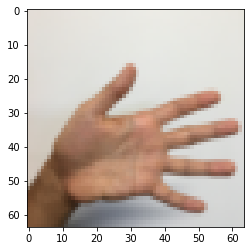

In [11]:
# Example of a picture
index = 0
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

- Preprocessing

In [12]:
# Flatten image data
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T

# Normalize image vectors
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.

# Convert training and test labels to one hot matrices
Y_train = onehot_encoder(Y_train_orig, C)
Y_test = onehot_encoder(Y_test_orig, C)

- Run

Cost after epoch 0: 1.855702
Cost after epoch 100: 1.017255
Cost after epoch 200: 0.733184
Cost after epoch 300: 0.573071
Cost after epoch 400: 0.468699
Cost after epoch 500: 0.381208
Cost after epoch 600: 0.313825
Cost after epoch 700: 0.253641
Cost after epoch 800: 0.203895
Cost after epoch 900: 0.166448
Cost after epoch 1000: 0.146694
Cost after epoch 1100: 0.107274
Cost after epoch 1200: 0.086552
Cost after epoch 1300: 0.059337
Cost after epoch 1400: 0.052209


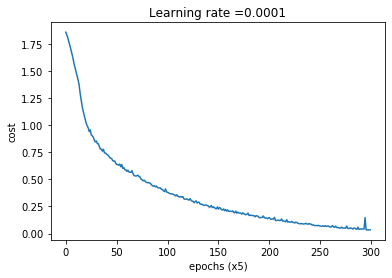

Train Accuracy:  0.9990741
Test Accuracy:  0.725


In [14]:
# 3-layer neural network
layers_dims=[X_train.shape[0], 25, 12, C]

parameters = model(X_train, Y_train, X_test, Y_test, layers_dims)